# Data examination and preprocessing

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, ADASYN
import re
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

## Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
PATH = 'drive/MyDrive/Data_mining/Competition2/'
train_data, test_data = pd.read_csv(PATH + 'train_data.csv', index_col=0), pd.read_csv(PATH + 'val_data.csv', index_col=0)

In [ ]:
# setting policy_id as index
train_data.set_index('policy_id', inplace=True)
test_data.set_index('policy_id', inplace=True)

In [ ]:
display(train_data.head(10))

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
policy_id,,,,,,,,,,,,,,,,,,,,,
ID47805,1.010772,0.11,0.375000,C12,34791,1,B2,M6,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
ID55076,0.473653,0.05,0.548077,C3,4076,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID45913,0.287461,0.06,0.586538,C19,27742,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID29181,0.547799,0.08,0.721154,C2,27003,1,B2,M6,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
ID41934,1.140288,0.08,0.471154,C9,17804,3,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
ID39359,0.995747,0.06,0.403846,C13,5410,3,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
ID03029,1.109322,0.09,0.500000,C8,8794,1,B1,M8,CNG,82.1Nm@3400rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,2,0
ID31257,0.848992,0.02,0.500000,C1,4990,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
ID37513,0.767478,0.00,0.394231,C16,16206,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0


In [ ]:
# concatenating data
train_data['Train'] = True
test_data['Train'] = False
data = pd.concat([train_data, test_data])

In [ ]:
# binary target value distribution
train_data['is_claim'].value_counts()

0    43881
1     2992
Name: is_claim, dtype: int64

In [ ]:
# get target variable
train_is_claim = train_data['is_claim']
data.drop('is_claim', axis = 1, inplace = True)

## Exploratory Data Analysis

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46873 entries, ID47805 to ID56423
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_tenure                     46873 non-null  float64
 1   age_of_car                        46873 non-null  float64
 2   age_of_policyholder               46873 non-null  float64
 3   area_cluster                      46873 non-null  object 
 4   population_density                46873 non-null  int64  
 5   make                              46873 non-null  int64  
 6   segment                           46873 non-null  object 
 7   model                             46873 non-null  object 
 8   fuel_type                         46873 non-null  object 
 9   max_torque                        46873 non-null  object 
 10  max_power                         46873 non-null  object 
 11  engine_type                       46873 non-null  object 
 12  a

In [ ]:
train_data.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000,46873.000000
mean,0.612319,0.069159,0.469529,18843.178504,1.761334,3.132955,1162.124037,3.626565,5.244640,4.852609,3850.249312,1672.262305,1553.418109,1385.165148,1.761035,0.063832
std,0.414403,0.056552,0.123003,17661.904605,1.135652,1.830582,265.974858,0.483721,0.429878,0.227785,311.072967,111.976906,79.616691,212.063923,1.388303,0.244456
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.000000,1051.000000,0.000000,0.000000
25%,0.210711,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.000000,1185.000000,0.000000,0.000000
50%,0.574637,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.000000,1335.000000,2.000000,0.000000
75%,1.039564,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.000000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.000000,1720.000000,5.000000,1.000000


### missing values

In [ ]:
# missing values
na_values = data.isna().sum()
print(na_values[na_values != 0])

Series([], dtype: int64)


### duplicates

In [ ]:
train_data.duplicated().sum()

0

### outliers

In [ ]:
def find_z_score_outliers(data):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []

    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > 3:
            outliers.append(i)
    return outliers

In [ ]:
num_cols = data.columns[data.dtypes != object]
for c in num_cols:
  outliers = find_z_score_outliers(data[c])
  print(f'Outliers for column {c}:\n', outliers)


Outliers for column policy_tenure:
 []
Outliers for column age_of_car:
 [0.26, 0.24, 0.29, 0.32, 0.31, 0.27, 0.29, 0.28, 0.27, 0.24, 0.24, 0.26, 0.26, 0.33, 0.36, 0.24, 0.29, 0.3, 0.24, 0.44, 0.26, 0.3, 0.27, 0.28, 0.26, 0.24, 0.3, 0.29, 0.3, 0.36, 0.31, 0.24, 0.3, 0.25, 0.27, 0.39, 0.36, 0.24, 0.34, 0.31, 0.24, 0.81, 0.24, 0.32, 0.24, 0.26, 0.24, 0.25, 0.26, 0.28, 0.25, 0.3, 0.31, 0.37, 0.28, 0.25, 0.3, 0.26, 0.27, 0.31, 0.27, 0.25, 0.33, 0.36, 0.24, 0.39, 0.3, 0.32, 0.33, 0.25, 0.24, 0.33, 0.62, 0.29, 0.26, 0.3, 0.3, 0.28, 0.3, 0.38, 0.36, 0.24, 0.29, 0.33, 0.25, 0.24, 0.27, 0.32, 0.26, 0.24, 0.25, 0.31, 0.28, 0.28, 0.25, 0.29, 0.25, 0.24, 0.28, 0.32, 0.25, 0.38, 0.27, 0.31, 0.3, 0.24, 0.39, 0.24, 0.36, 0.24, 0.32, 0.25, 0.24, 0.3, 0.26, 0.29, 0.28, 0.24, 0.32, 0.27, 0.28, 0.27, 0.25, 0.27, 0.3, 0.32, 0.25, 0.24, 0.33, 0.25, 0.32, 0.3, 0.24, 0.33, 0.28, 0.24, 0.25, 0.24, 0.25, 0.3, 0.28, 0.24, 0.24, 0.25, 0.24, 0.28, 0.31, 0.24, 0.31, 0.3, 0.25, 0.24, 0.31, 0.24, 0.24, 0.36, 0.3, 0.2

### numeric columns visualization with histogram

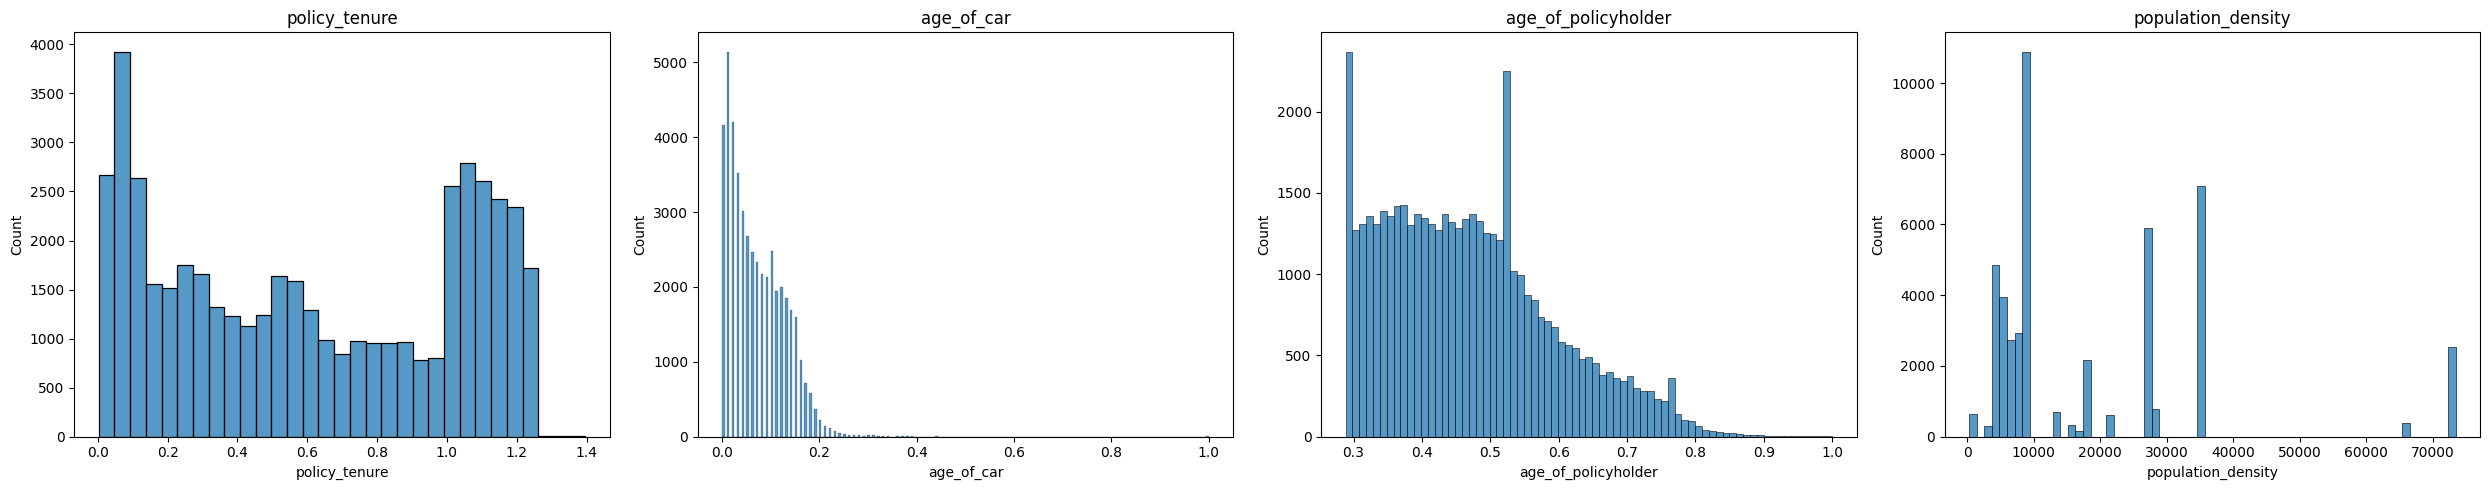

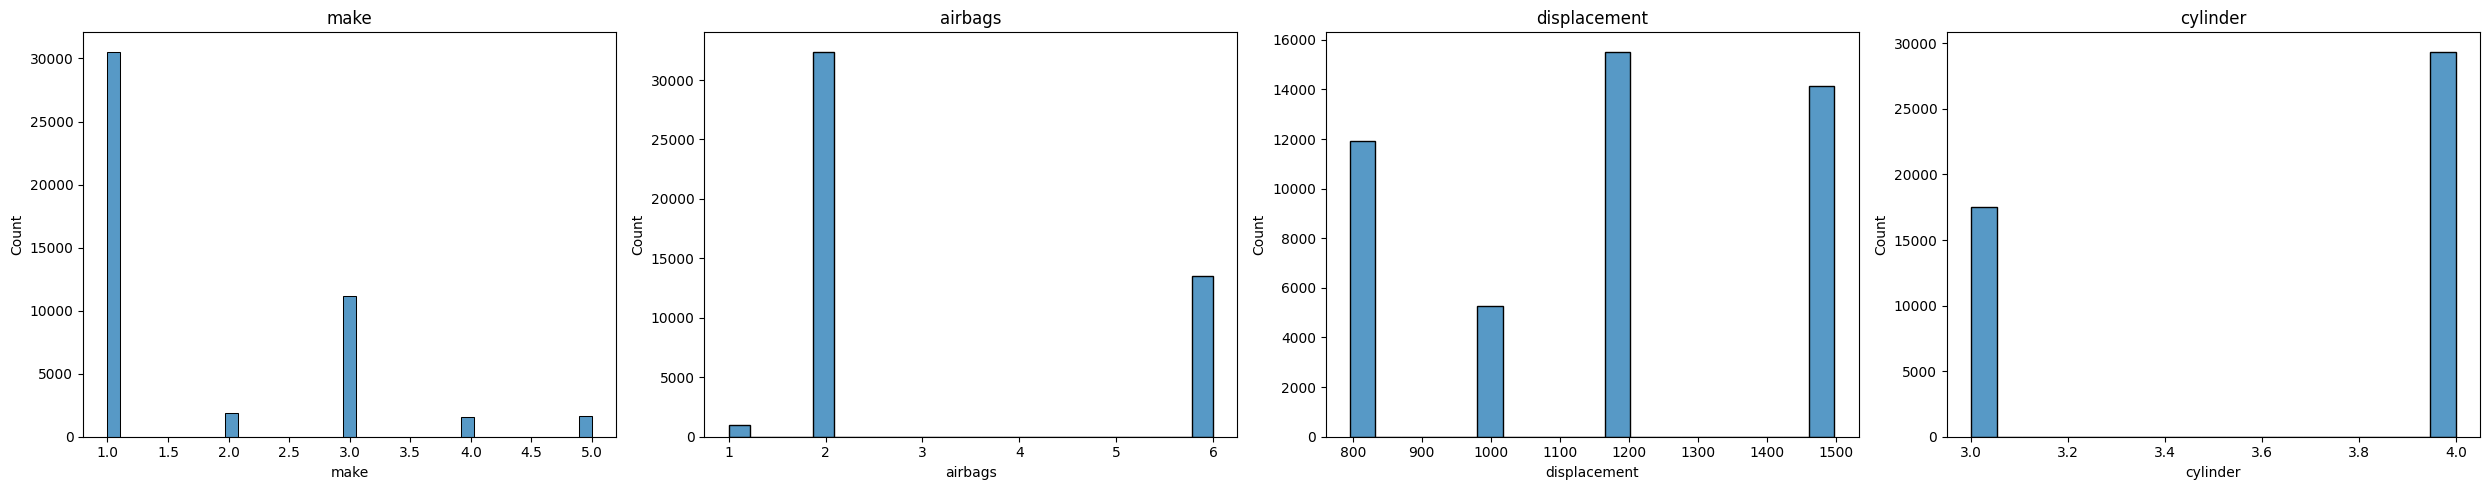

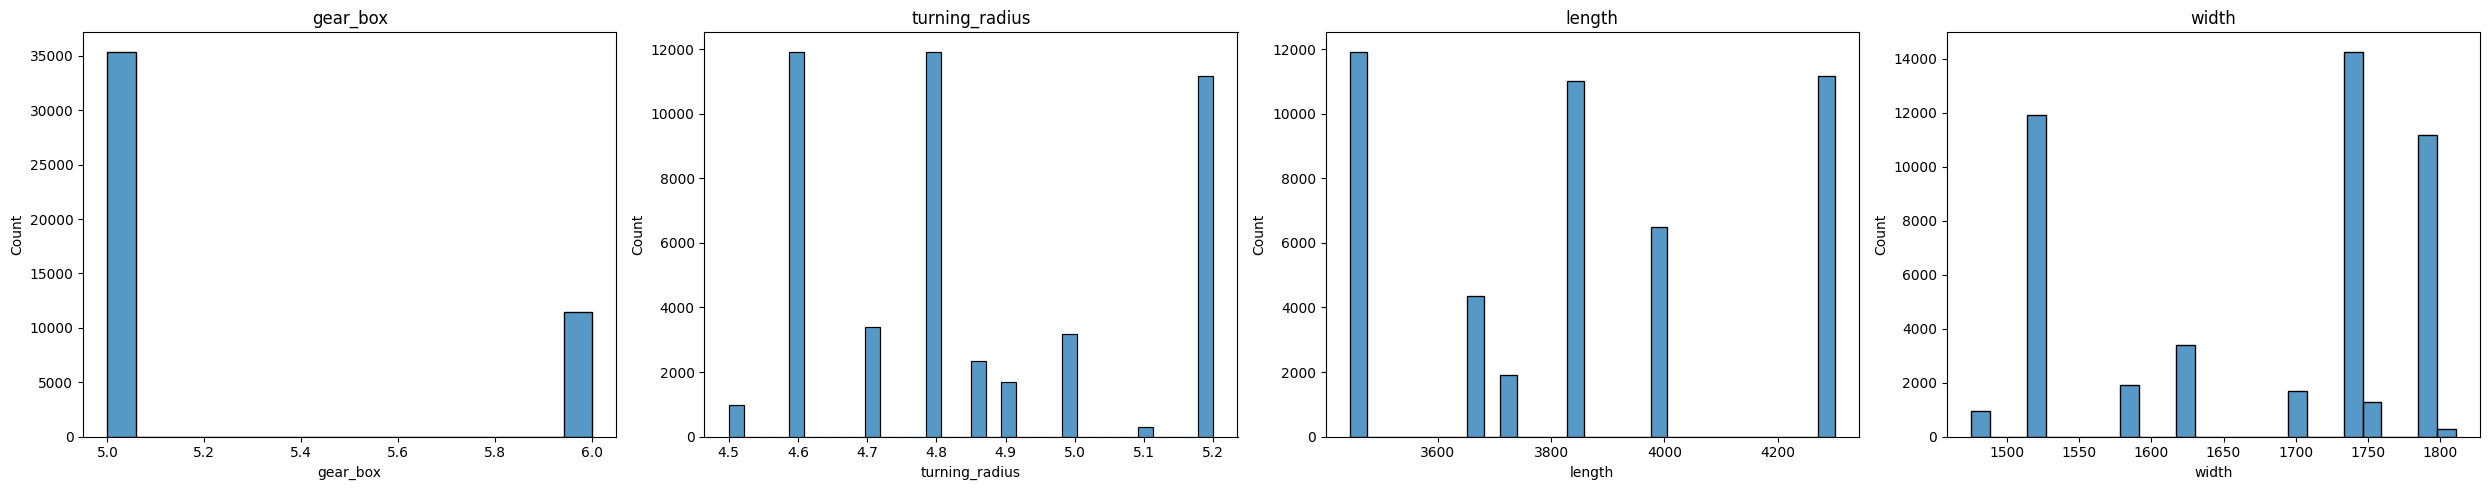

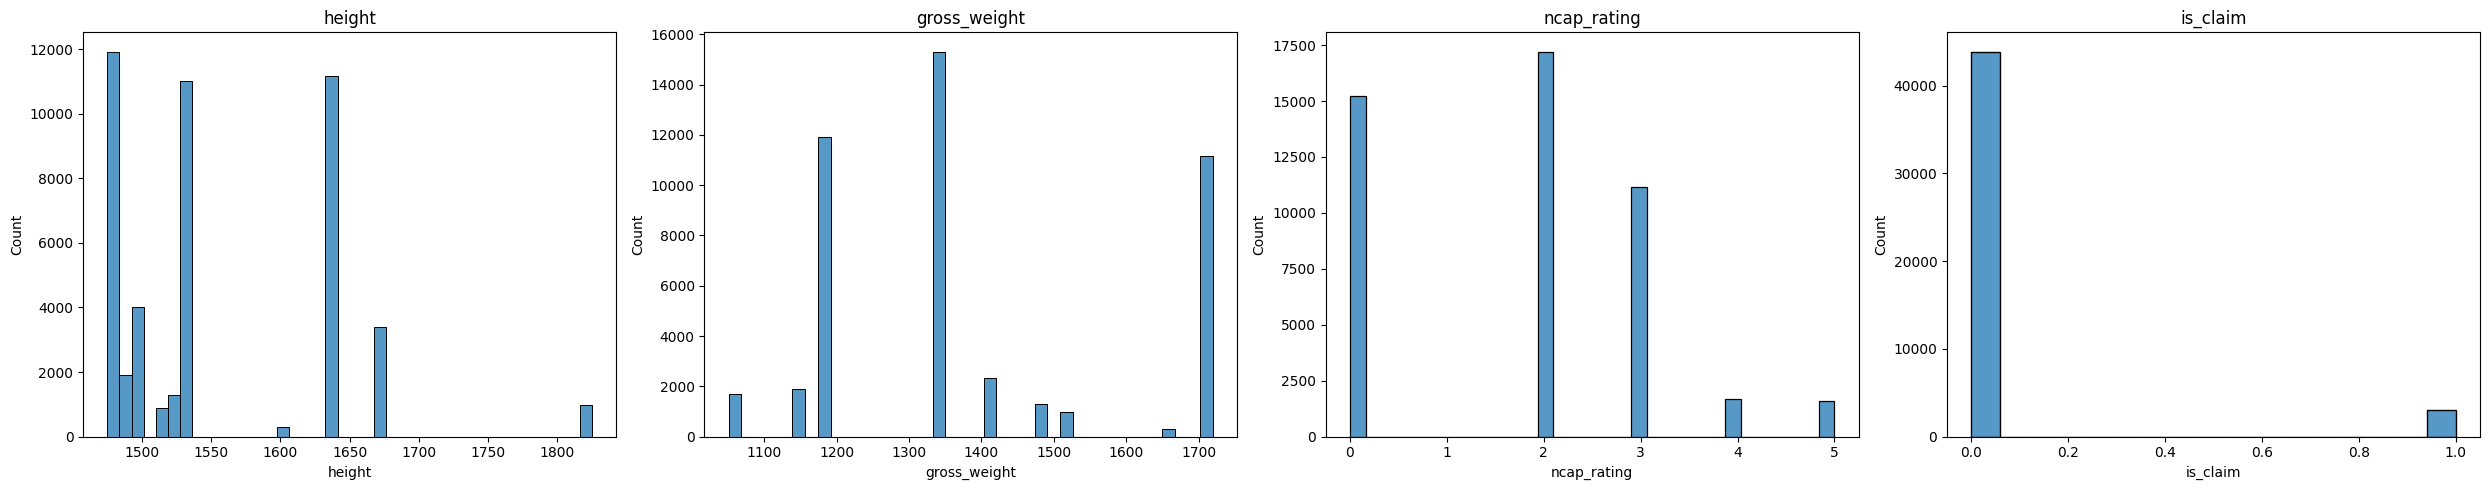

In [ ]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
columns = 4
num_batches = math.ceil(len(numeric_columns) / columns)

for batch in range(num_batches):
    batch_columns = numeric_columns[batch * columns:(batch + 1) * columns]

    plt.figure(figsize=(25, 5))
    for i, col in enumerate(batch_columns):
        plt.subplot(1, columns, i + 1)
        sns.histplot(train_data[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()


### barcharts for categorical variables

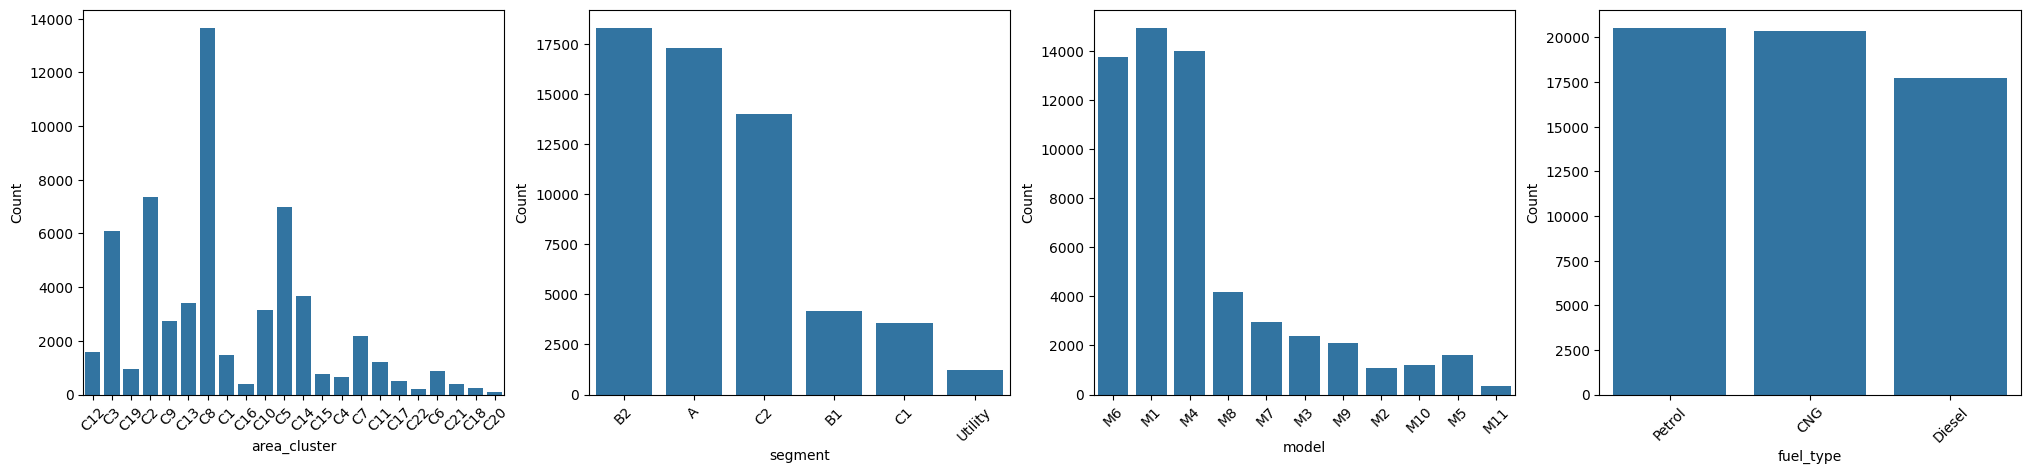

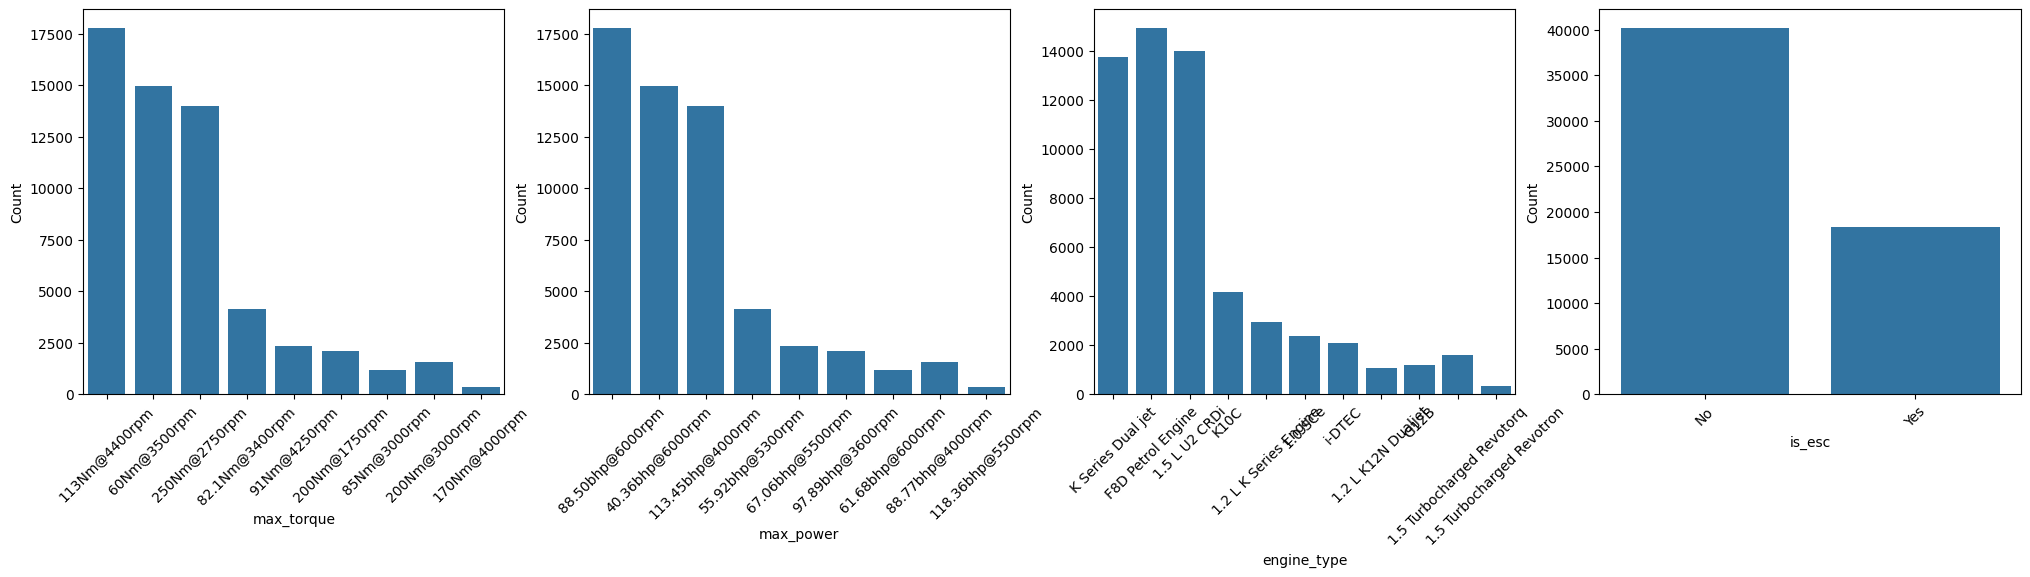

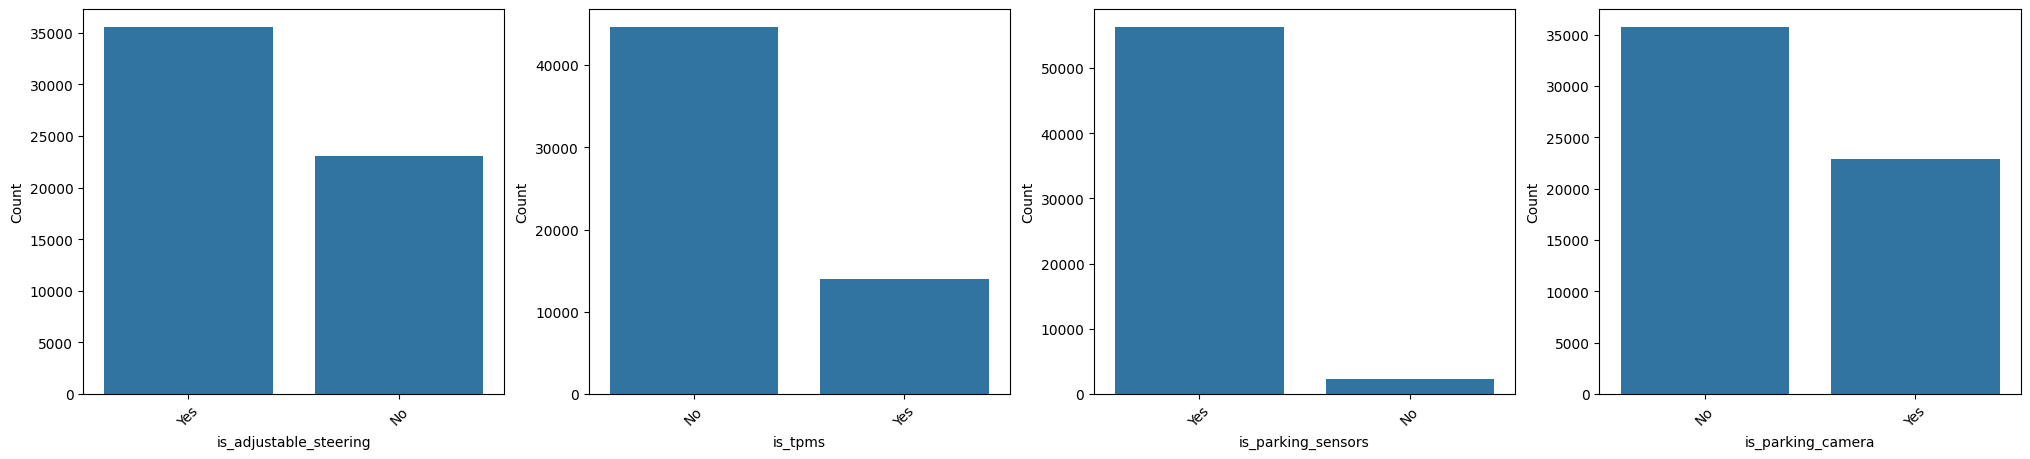

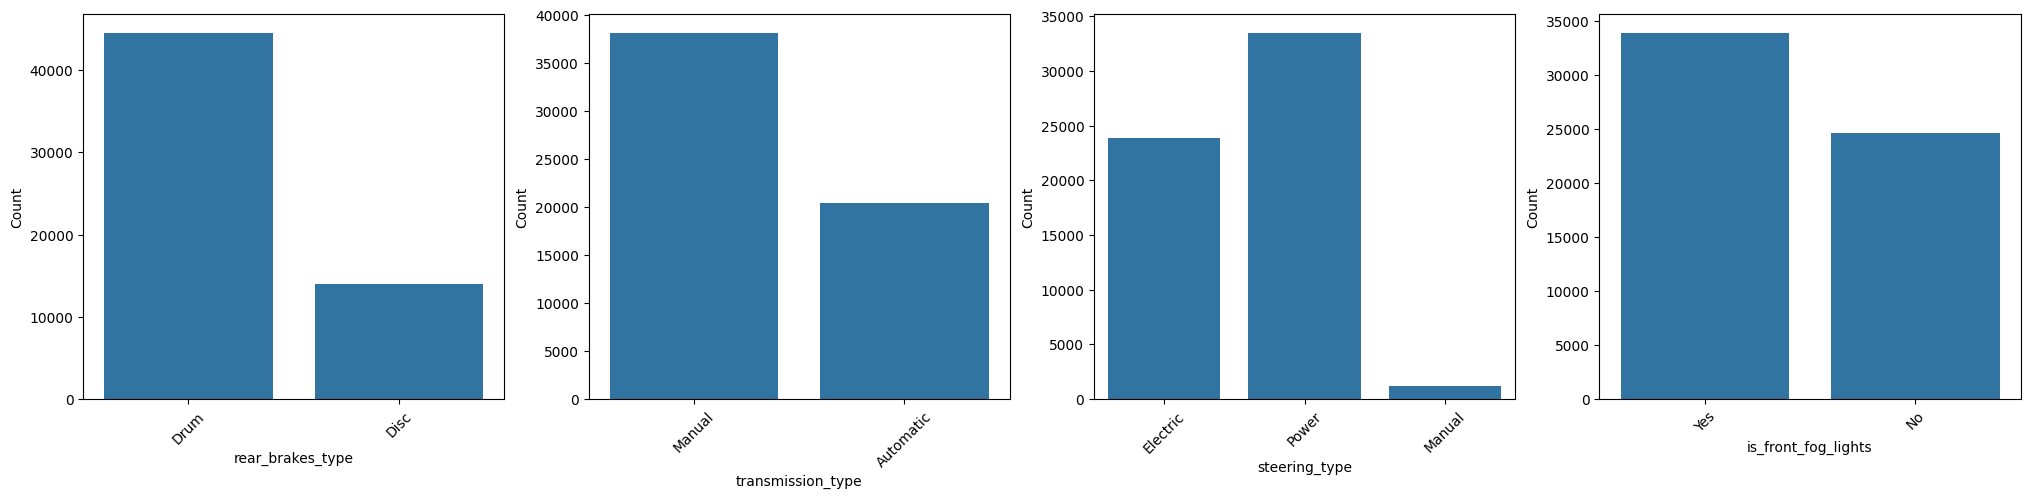

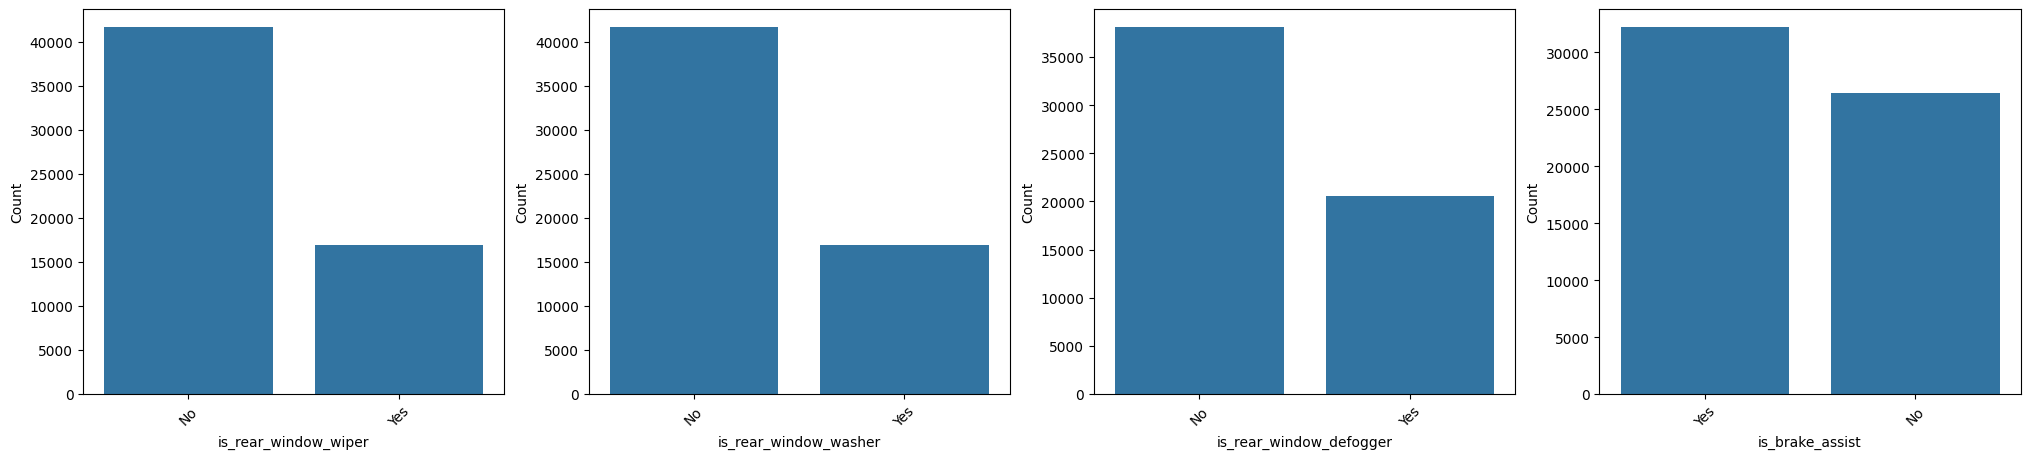

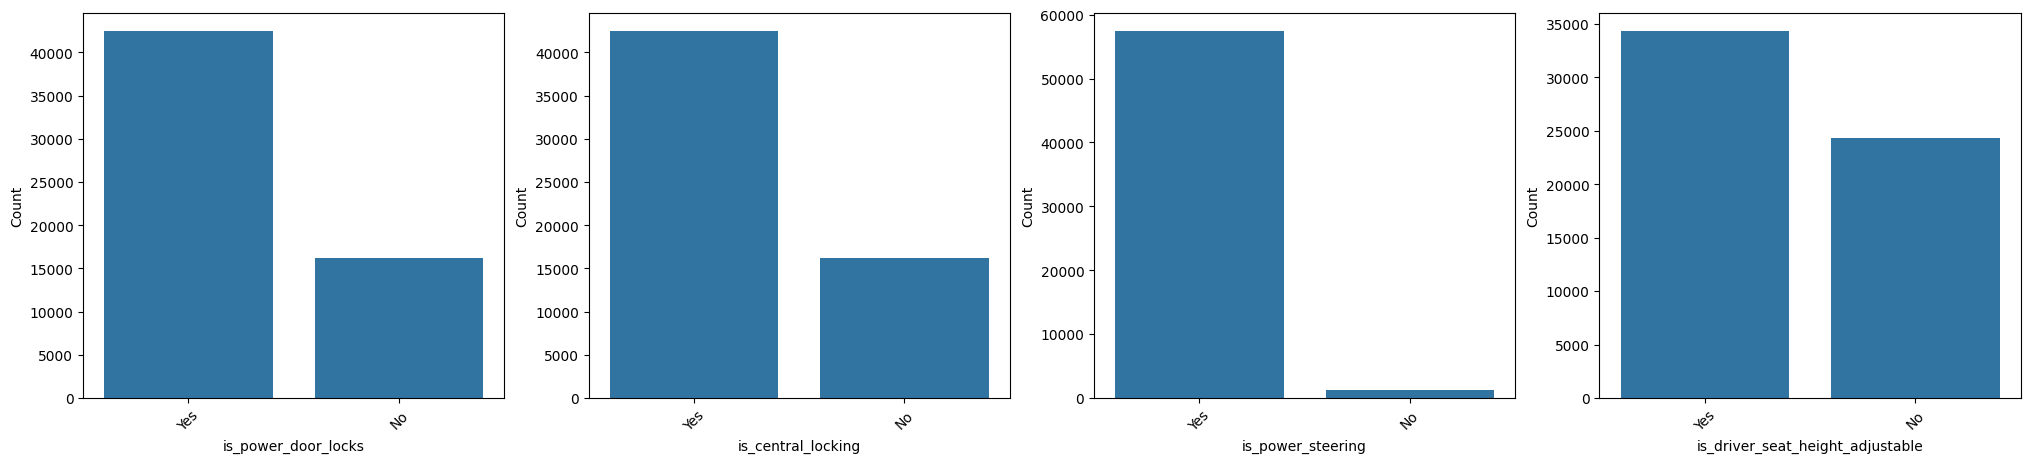

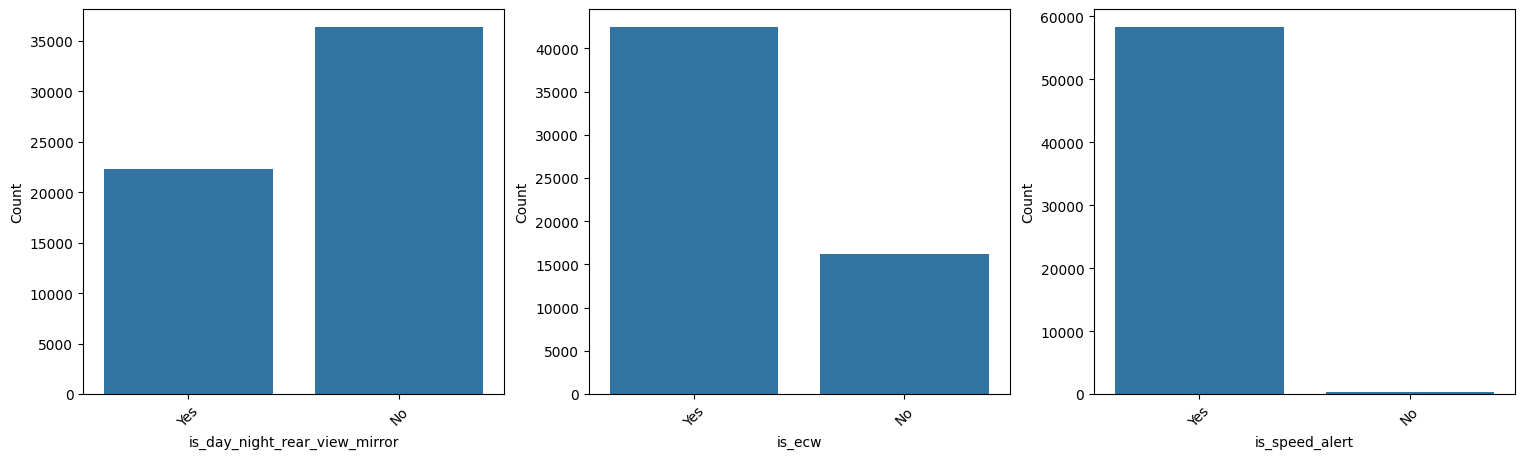

In [ ]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

columns = 4
num_batches = math.ceil(len(categorical_columns) / columns)

for batch in range(num_batches):
    batch_columns = categorical_columns[batch * columns:(batch + 1) * columns]

    plt.figure(figsize=(25, 5))
    for i, col in enumerate(batch_columns):
      plt.subplot(1, columns, i + 1)
      sns.countplot(x=col, data=data)
      plt.xticks(rotation=45)
      plt.xlabel(col)
      plt.ylabel('Count')


### correlation heatmap

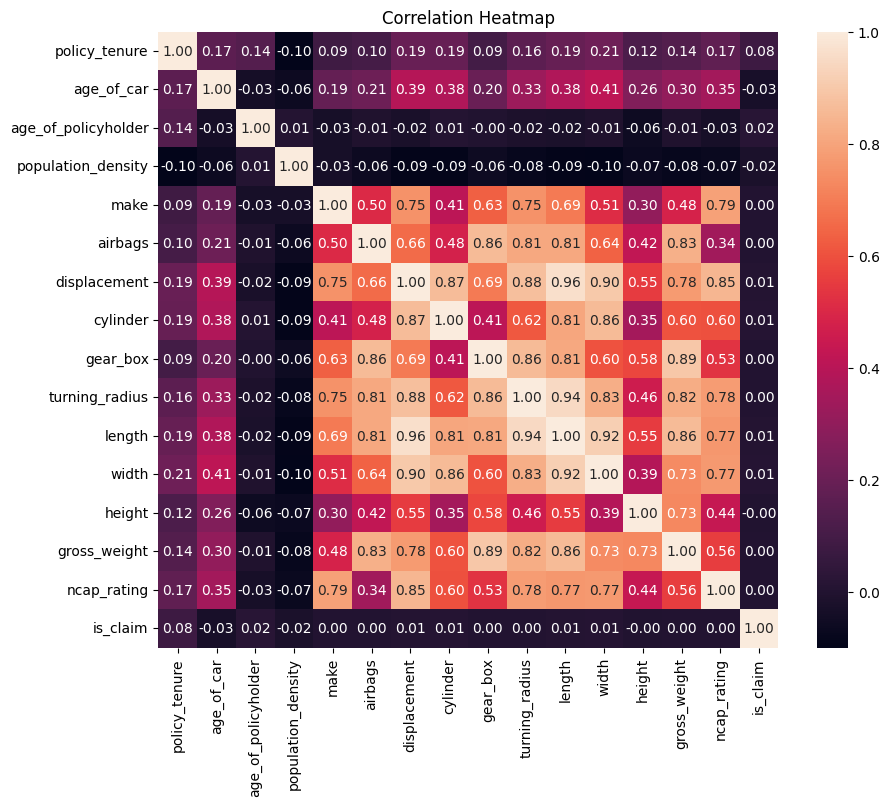

In [ ]:
corr = train_data.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# analyzing correlations
num_cols = data.columns[data.dtypes != object]
num_corr_matrix = data[num_cols].corr()

# checking strong correlations - those above +/-0.7 correlation value
strong_correlations = num_corr_matrix[((num_corr_matrix > 0.85) | (num_corr_matrix < -0.85))]

strong_correlation_list = [(', '.join(sorted([index, column])), strong_correlations.loc[index, column]) for index in strong_correlations.index for column in strong_correlations.columns if index != column and not np.isnan(strong_correlations.loc[index, column])]

for correlation in set(strong_correlation_list):
    print(correlation)

('displacement, length', 0.9616545336630702)
('gear_box, gross_weight', 0.8946387111559776)
('length, turning_radius', 0.944898998070402)
('gross_weight, length', 0.8617234661522444)
('displacement, width', 0.8993017824181057)
('cylinder, width', 0.8624304382655004)
('gear_box, turning_radius', 0.8617398713807202)
('length, width', 0.9159184100153636)
('airbags, gear_box', 0.8595558225355691)
('cylinder, displacement', 0.8662310750529859)
('displacement, turning_radius', 0.8754071279308178)


In [ ]:
# dropping columns with high corelation
data = data.drop(columns=['width', 'turning_radius'])

### check categorical column values

In [ ]:
cat_cols = data.columns[data.dtypes == object]
for c in cat_cols:
  print(c, ':', data[c].unique())

area_cluster : ['C12' 'C3' 'C19' 'C2' 'C9' 'C13' 'C8' 'C1' 'C16' 'C10' 'C5' 'C14' 'C15'
 'C4' 'C7' 'C11' 'C17' 'C22' 'C6' 'C21' 'C18' 'C20']
segment : ['B2' 'A' 'C2' 'B1' 'C1' 'Utility']
model : ['M6' 'M1' 'M4' 'M8' 'M7' 'M3' 'M9' 'M2' 'M10' 'M5' 'M11']
fuel_type : ['Petrol' 'CNG' 'Diesel']
max_torque : ['113Nm@4400rpm' '60Nm@3500rpm' '250Nm@2750rpm' '82.1Nm@3400rpm'
 '91Nm@4250rpm' '200Nm@1750rpm' '85Nm@3000rpm' '200Nm@3000rpm'
 '170Nm@4000rpm']
max_power : ['88.50bhp@6000rpm' '40.36bhp@6000rpm' '113.45bhp@4000rpm'
 '55.92bhp@5300rpm' '67.06bhp@5500rpm' '97.89bhp@3600rpm'
 '61.68bhp@6000rpm' '88.77bhp@4000rpm' '118.36bhp@5500rpm']
engine_type : ['K Series Dual jet' 'F8D Petrol Engine' '1.5 L U2 CRDi' 'K10C'
 '1.2 L K Series Engine' '1.0 SCe' 'i-DTEC' '1.2 L K12N Dualjet' 'G12B'
 '1.5 Turbocharged Revotorq' '1.5 Turbocharged Revotron']
is_esc : ['No' 'Yes']
is_adjustable_steering : ['Yes' 'No']
is_tpms : ['No' 'Yes']
is_parking_sensors : ['Yes' 'No']
is_parking_camera : ['No' 'Yes']
re

## Feature engineering

In [ ]:
data['torque'] = data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
data['rpm'] = data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])
data['power'] = data['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])

# converting to numeric
data['torque'] = pd.to_numeric(data['torque'])
data['rpm'] = pd.to_numeric(data['rpm'])
data['power'] = pd.to_numeric(data['power'])

# torque to RPM ratio
data['torque to rpm ratio'] = data['torque'] / data['rpm']

# power to RPM ratio
data['power to rpm ratio'] = data['power'] / data['rpm']

In [ ]:
data['torque'].unique()

array([113. ,  60. , 250. ,  82.1,  91. , 200. ,  85. , 170. ])

In [ ]:
data['power'].unique()

array([ 88.5 ,  40.36, 113.45,  55.92,  67.06,  97.89,  61.68,  88.77,
       118.36])

In [ ]:
data['power to rpm ratio'].unique()

array([0.02011364, 0.01153143, 0.04125455, 0.01644706, 0.01577882,
       0.05593714, 0.02056   , 0.02959   ])

In [ ]:
# deleting redundant columns
data.drop('max_torque', axis=1,inplace=True)
data.drop('rpm',axis=1,inplace=True)
data.drop('torque',axis=1,inplace=True)
data.drop('max_power',axis=1,inplace=True)
data.drop('power',axis=1,inplace=True)

## Encoding categorical values

In [ ]:
# encoding binary values
data['segment'] = data['segment'].map({'A': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5, 'Utility': 6})

In [ ]:
# encoding binary values
binary_columns = [
    'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
    'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

for col in binary_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [ ]:
# one-hot encoding the rest of categorical columns
cat_cols = data.columns[data.dtypes == object]
for col_name in cat_cols:
    if col_name == 'Train':
        continue
    dummies = pd.get_dummies(data[col_name], prefix = col_name, drop_first = (len(pd.unique(data[col_name])) <= 2))
    data = pd.concat([data.drop(col_name, axis = 1), dummies], axis = 1)

In [ ]:
data.columns[data.dtypes == object]

Index([], dtype='object')

 # Random forest

In [ ]:
# re-splitting train and test data
train_data = data[data['Train']].drop('Train', axis = 1)
test_data = data[~data['Train']].drop('Train', axis = 1)

## Pipeline

In [ ]:
# defining pipeline
#smote = SMOTE()
#undersampler = RandomUnderSampler()
#oversampler = RandomOverSampler()
#b_smote = BorderlineSMOTE()
adasyn = ADASYN()
clf = RandomForestClassifier()

pipeline = Pipeline([('adasyn', adasyn), ('clf', clf)])

pipeline.get_params()

{'memory': None,
 'steps': [('adasyn', ADASYN()), ('clf', RandomForestClassifier())],
 'verbose': False,
 'adasyn': ADASYN(),
 'clf': RandomForestClassifier(),
 'adasyn__n_jobs': None,
 'adasyn__n_neighbors': 5,
 'adasyn__random_state': None,
 'adasyn__sampling_strategy': 'auto',
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_nodes': None,
 'clf__max_samples': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 100,
 'clf__n_jobs': None,
 'clf__oob_score': False,
 'clf__random_state': None,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [ ]:
param_grid = {
    'clf__n_estimators':[100,150,250],
    'clf__max_depth': [4,5,6],
    'adasyn__n_neighbors': [1,2],
    #'b_smote__k_neighbors': [3, 5, 7],
    #'b_smote__m_neighbors': [5, 10, 15],
    #'b_smote__sampling_strategy': ['auto', 0.1, 0.3, 0.8],
    #'oversampler__sampling_strategy': ['auto', 0.1, 0.3, 0.8, 'not majority'],
    #'undersampler__sampling_strategy': ['auto', 0.1, 0.3, 0.8, 'majority']
}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_is_claim, test_size = 0.2, random_state=12)
rf = RandomForestClassifier()

In [ ]:
gs = GridSearchCV(pipeline, param_grid=param_grid, scoring='balanced_accuracy', verbose=1, n_jobs=-1)
gs.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('adasyn', ADASYN()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'adasyn__n_neighbors': [1, 2],
                         'clf__max_depth': [4, 5, 6],
                         'clf__n_estimators': [100, 150, 250]},
             scoring='balanced_accuracy', verbose=1)

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adasyn__n_neighbors,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,7.701235,0.420013,0.155743,0.043865,1,6,150,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 6...",0.592556,0.598205,0.594734,0.608869,0.611928,0.601258,0.007738,1
4,6.929291,0.714463,0.105403,0.003290,1,5,150,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 5...",0.588239,0.603955,0.598540,0.597384,0.613646,0.600353,0.008349,2
5,10.337108,0.564573,0.192029,0.033535,1,5,250,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 5...",0.595692,0.601946,0.595550,0.598709,0.608265,0.600032,0.004735,3
3,4.693859,0.644895,0.074302,0.002518,1,5,100,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 5...",0.584018,0.606016,0.593775,0.598808,0.610379,0.598599,0.009271,4
8,12.018812,0.388939,0.192751,0.010219,1,6,250,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 6...",0.582089,0.604333,0.591728,0.602661,0.610828,0.598328,0.010182,5
6,5.218952,0.573322,0.101975,0.034290,1,6,100,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 6...",0.574180,0.592286,0.595490,0.605127,0.611278,0.595672,0.012699,6
16,7.799955,0.768995,0.149488,0.043267,2,6,150,"{'adasyn__n_neighbors': 2, 'clf__max_depth': 6...",0.588270,0.592534,0.596438,0.603757,0.595729,0.595346,0.005100,7
15,5.815517,0.736862,0.092964,0.003899,2,6,100,"{'adasyn__n_neighbors': 2, 'clf__max_depth': 6...",0.572449,0.596374,0.596126,0.600997,0.602517,0.593693,0.010915,8
2,8.790918,0.704001,0.184469,0.037585,1,4,250,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 4...",0.570457,0.603482,0.592334,0.594377,0.607736,0.593677,0.012925,9
1,6.755434,1.227982,0.112709,0.024261,1,4,150,"{'adasyn__n_neighbors': 1, 'clf__max_depth': 4...",0.576050,0.600675,0.584693,0.591133,0.606837,0.591877,0.010990,10


In [ ]:
rf=gs.best_estimator_['clf']

In [ ]:
print('Balanced accuracy of the best model: ', balanced_accuracy_score(y_val, rf.predict(x_val)))

Balanced accuracy of the best model:  0.6162370999539466
